Założenia:

1. Wybieramy temat. Może być to temat z poprzedniego projektu – o ile nie będzie realizować tego samego lub podobnego projektu trzeci raz.
2. Wyznaczamy zmienną celu.
3. Dokonujemy eksploracji zbioru. Uzupełniamy braki danych. Dokonujemy wstępnej selekcji zmiennych.
4. Dzielimy zbiór danych na treningowy testowy i w miarę możliwości na walidacyjny.
5. Tworzymy różnego rodzaju modele sieci neuronowych – sprawdzając różne możliwe parametry.
6. Porównujemy i wybieramy najlepszy model.
7. Dokonujemy ostatecznej oceny wybranego modelu na zbiorze walidacyjnym.
8. Porównujemy rozwiązanie z przynajmniej jednym, poznanym modelem w bloku ML.
9. Wskazujemy uzysk dla firmy / odbiorcy (np. ile pieniędzy z tego będzie miała, jak wdrożenie wpłynie na rozpoznawalność przypadków, dla których firma wykona działania prewencyjne itd.) – to jest bardzo ważny punkt.
10. Budujemy aplikację wykorzystującą model.
11. Na prezentacji powinna znaleźć się krótka analiza zmiennych, omówienie wyników wszystkich zastosowanych technik modelowania i ich porównanie, wybór modelu i przede wszystkim wartość dodana jaką niesie za sobą wdrożenie.

7. Sortownia owoców
* Klasyfikacja jabłek
* aplikacja na taśmie w fabryce dżemów
* typ zadania: klasyfikacja zdjęć
* wersja podstawowa: trzy klasy silnie odróżniające się od siebie
* wersja zaawansowana: wszystkie klasy
* https://www.kaggle.com/chrisfilo/fruit-recognition


In [100]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support
import cv2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
import datetime
import os
import seaborn as sns
import glob
from sklearn.utils import shuffle
# import tensorflow.keras.layers as L
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, plot_roc_curve, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
import seaborn as sns
import warnings
from time import time
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import itertools

In [2]:
def printmd(string):   
    display(Markdown(string))
    
np.random.seed(123) # Add random seed of training for reproducibility

def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [3]:
images = []
dirp = "data/Apple/"
for e in os.listdir(dirp):
    if e == "Apple A":
        images += load_images_from_folder(dirp+"/"+e,True,label = "Apple A")
    elif e == "Apple B":
        images += load_images_from_folder(dirp+"/"+e,True,label = "Apple B")
    elif e == "Apple C":
        images += load_images_from_folder(dirp+"/"+e,True,label = "Apple A")
    elif e == "Apple D":
        images += load_images_from_folder(dirp+"/"+e,True,label = "Apple C")
    elif e == "Apple E":
        images += load_images_from_folder(dirp+"/"+e,True,label = "Apple A")
    elif e == "Apple F":
        images += load_images_from_folder(dirp+"/"+e,True,label = "Apple C")


In [4]:
data_df = pd.DataFrame(images, columns = ["fruit", "path"])

data_df = shuffle(data_df, random_state = 123)
data_df = data_df.reset_index(drop=True)

fruit_names = sorted(data_df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
data_df["label"] = data_df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

# data_df

{'Apple A': 0, 'Apple B': 1, 'Apple C': 2}


In [5]:
data_df.groupby('fruit').count()

path  label
fruit               
Apple A  2358   2358
Apple B   740    740
Apple C  3063   3063

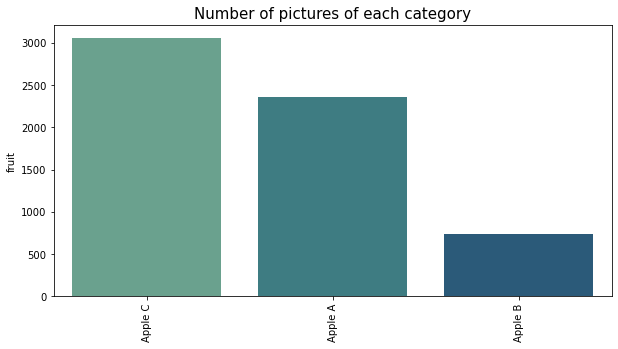

In [6]:
fc = data_df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = fc.index, y = fc, palette = "crest")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

fruit    300
path     300
label    300
dtype: int64


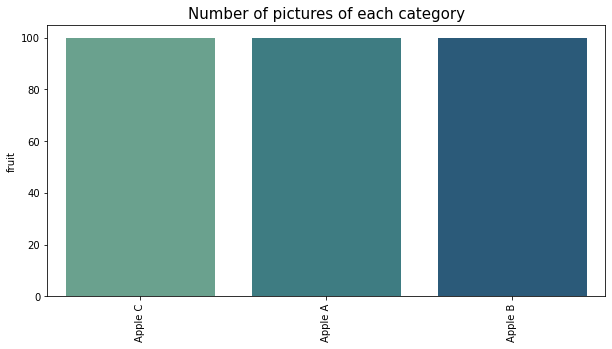

In [7]:
# w celu testowania modeli zmniejszam zbiór do 100 próbek z kazdej kategorii
num_patterns = 100
img_simp_ds = pd.DataFrame()
for fr in data_df['fruit'].unique():
    img_simp_ds = img_simp_ds.append(data_df[data_df['fruit']==fr][0:num_patterns], ignore_index=True)
print(img_simp_ds.count())
model_data = img_simp_ds

fc = model_data["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = fc.index, y = fc, palette = "crest")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

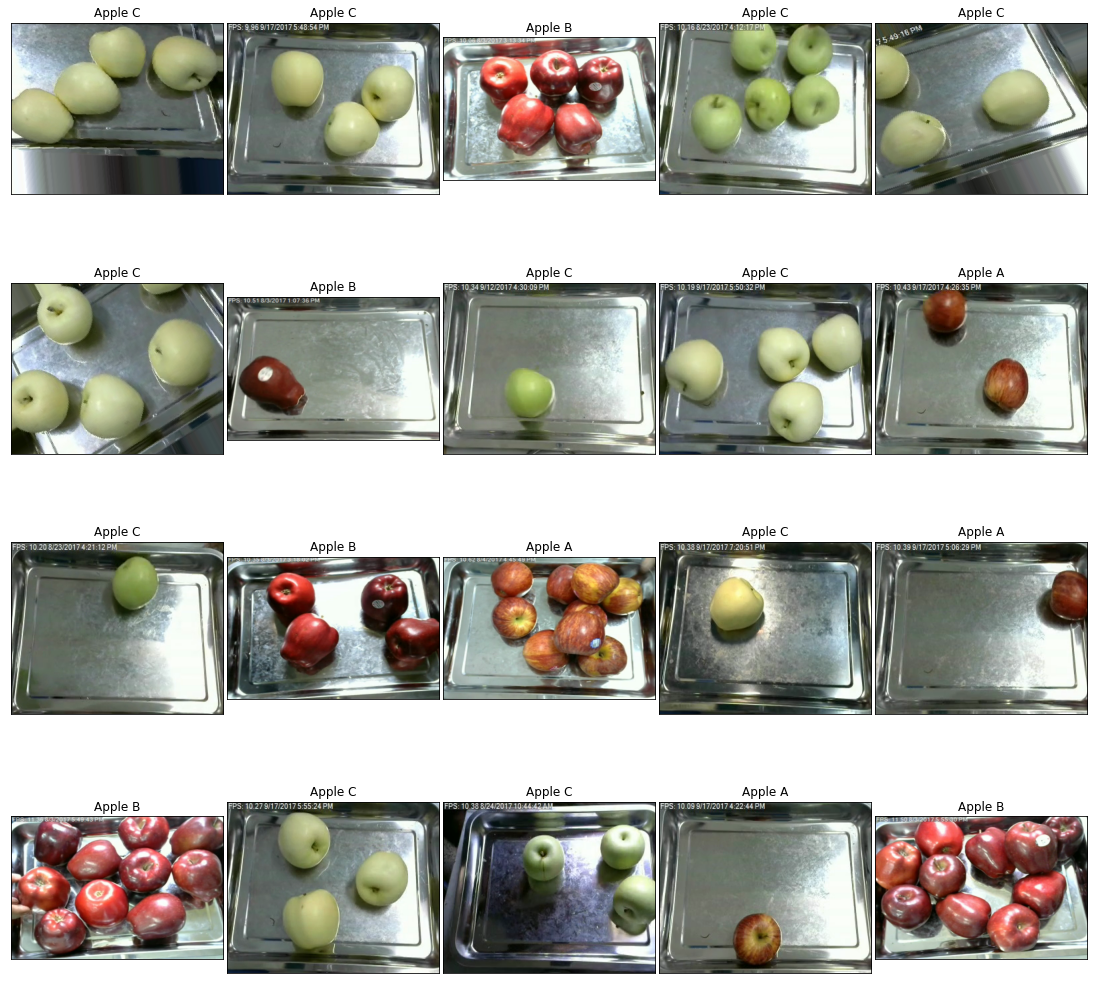

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data_df.path[i+20]))
    ax.set_title(data_df.fruit[i+20], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

In [9]:
# wszystkie zdjecia w takim samym rozmiarze
x = []
for i in range(len(model_data.path)):
    img = plt.imread(model_data.path[i])
    img = cv2.resize(img, (224,224))
    x.append(img)

In [10]:
x = np.array(x)
x.shape

(300, 224, 224, 3)

In [11]:
y = np.array(model_data['label'])

In [12]:
y.shape

(300,)

In [ ]:
# oversample = RandomOverSampler(sampling_strategy='minority')
# x, y = oversample.fit_resample(x, y)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [14]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

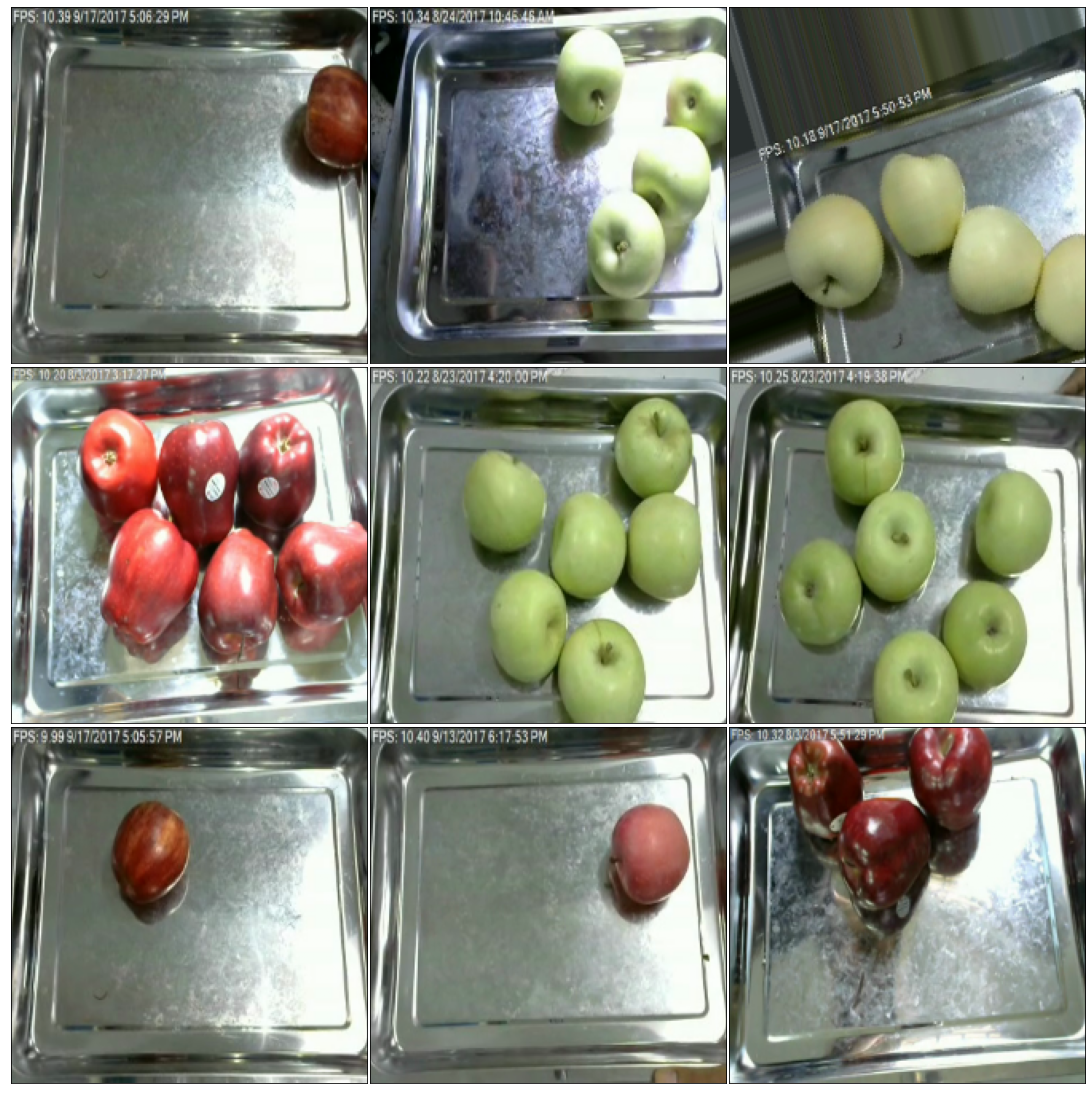

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])
    # ax.set_title(y_train[i+20], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

In [16]:
# transformujemy y_test
y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()
# podglądamy
y_test = y_test.astype(np.float32)

# transformujemy y_train
y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1)).toarray()
# podglądamy
y_train = y_train.astype(np.float32)

print("y_test.shape: ", y_test.shape)
print("y_train.shape: ", y_train.shape)


y_test.shape:  (60, 3)
y_train.shape:  (240, 3)


In [17]:
# zmieniamy shape pod konwolucje
x_test = x_test.reshape(-1,224,224,3)
x_train = x_train.reshape(-1,224,224,3)

In [18]:
(x_train.shape[0]*0.95)%33

30.0

In [19]:
model_1 = tf.keras.Sequential()
model_1.add(layers.Conv2D(32,kernel_size=3,strides=1, activation='relu',padding='same',input_shape=x_train.shape[1:]))
model_1.add(layers.MaxPooling2D((2,2),strides=2,padding="SAME"))
model_1.add(layers.Conv2D(64,kernel_size=3,strides=1, activation='relu',padding='same'))
model_1.add(layers.Conv2D(64,kernel_size=3,strides=1, activation='relu',padding='same'))
model_1.add(layers.MaxPooling2D((2,2),strides=2,padding="SAME"))
model_1.add(layers.Conv2D(128,kernel_size=3,strides=1, activation='relu',padding='same'))
model_1.add(layers.Conv2D(128,kernel_size=3,strides=1, activation='relu',padding='same'))
model_1.add(layers.MaxPooling2D((2,2),strides=2,padding="SAME"))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(512,activation='relu'))
model_1.add(layers.Dropout(0.2))
model_1.add(layers.Dense(3,activation='softmax'))


opt = tf.keras.optimizers.Adam()
loss=tf.keras.losses.CategoricalCrossentropy()

model_1.compile(optimizer=opt,loss=loss,metrics=["accuracy"])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 128)       1

In [20]:
# dodajemy zapisywanie logów do tensorboard'a
log_dir = "logs\\" + "model_1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [21]:
start = time()
history_1=model_1.fit(x= x_train,y=y_train,epochs=10,batch_size=33, validation_split=0.05, callbacks=[tensorboard_callback])
end = time()
time_model_1 = round(end-start,4)

Epoch 1/10
7/7 [==============================] - 20s 3s/step - loss: 4.8268 - accuracy: 0.2325 - val_loss: 1.0931 - val_accuracy: 0.3333
Epoch 2/10
7/7 [==============================] - 16s 2s/step - loss: 1.0805 - accuracy: 0.4693 - val_loss: 1.0688 - val_accuracy: 0.3333
Epoch 3/10
7/7 [==============================] - 15s 2s/step - loss: 0.9719 - accuracy: 0.5395 - val_loss: 0.8784 - val_accuracy: 0.6667
Epoch 4/10
7/7 [==============================] - 16s 2s/step - loss: 0.7520 - accuracy: 0.6886 - val_loss: 0.4808 - val_accuracy: 0.9167
Epoch 5/10
7/7 [==============================] - 17s 2s/step - loss: 0.4684 - accuracy: 0.7939 - val_loss: 0.1962 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 16s 2s/step - loss: 0.3385 - accuracy: 0.8772 - val_loss: 0.2498 - val_accuracy: 0.9167
Epoch 7/10
7/7 [==============================] - 16s 2s/step - loss: 0.2176 - accuracy: 0.9342 - val_loss: 0.1406 - val_accuracy: 0.9167
Epoch 8/10
7/7 [==================

In [22]:
model_1.save_weights("weights/model_1")

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        20
           1       0.96      0.96      0.96        23
           2       0.92      0.71      0.80        17

    accuracy                           0.87        60
   macro avg       0.88      0.85      0.86        60
weighted avg       0.88      0.87      0.87        60



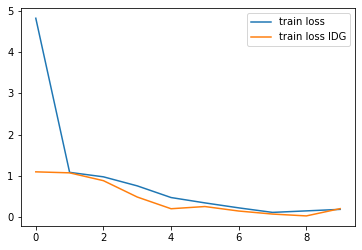

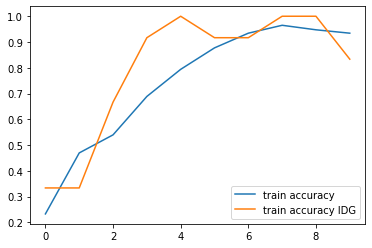

In [23]:
y_pred = model_1.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.legend(["train loss", "train loss IDG","validation loss", "validation IDG loss"])
plt.show()

plt.plot(history_1.history["accuracy"])
plt.plot(history_1.history["val_accuracy"])
plt.legend(["train accuracy", "train accuracy IDG","validation accuracy", "validation IDG accuracy"])
plt.show()

In [24]:
def create_cnn_model(inShape, convNum, hNum, hAct, outNum, loss):
    """
    :param inShape: kształt wejścia, h*w*c
    :param convNum: lista ilości featerów w warstwach konwolucyjnych
    :param hNum: lista ilości neuronów w poszczególnych warstwach ukrytych
    :param hAct: rodzaj aktywacji w warstwach ukrytych, str
    :param outNum: ilość neutronów
    :param loss: funkcja kosztu
    """
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(inShape)))
    for idx, oneConvNum in enumerate(convNum):
        model.add(layers.Conv2D(filters=oneConvNum,kernel_size=3,strides=1,padding="SAME",activation="relu"))
        model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2,padding="SAME" ))
    model.add(layers.Flatten())
    for idx, oneHidNum in enumerate(hNum):
        model.add(layers.Dense(oneHidNum, activation=hAct))
    model.add(layers.Dense(outNum))
    model.add(layers.Softmax())
    print(model.summary())
    
    opt = tf.keras.optimizers.Adam()
    
    model.compile(optimizer=opt,loss=loss,metrics=["accuracy"])
    
    return model

In [25]:
model_2 = create_cnn_model(
    inShape=x_train.shape[1:],
    convNum=[32,64,128, 256],
    hNum=[50],
    hAct="relu",
    outNum=3,
    loss=tf.keras.losses.CategoricalCrossentropy()
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 256)      

In [26]:
# dodajemy zapisywanie logów do tensorboard'a
log_dir = "logs\\" + "model_2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [27]:
start = time()
history_2 = model_2.fit(
    x=x_train,
    y=y_train,
    batch_size=33,
    epochs=10,
    validation_split=0.05,
    callbacks=[tensorboard_callback]
)
end = time()
time_model_2 = round(end-start,4)

Epoch 1/10
7/7 [==============================] - 13s 2s/step - loss: 1.2173 - accuracy: 0.3202 - val_loss: 1.0772 - val_accuracy: 0.5833
Epoch 2/10
7/7 [==============================] - 11s 2s/step - loss: 1.0234 - accuracy: 0.5088 - val_loss: 0.8659 - val_accuracy: 0.7500
Epoch 3/10
7/7 [==============================] - 10s 1s/step - loss: 0.7794 - accuracy: 0.6667 - val_loss: 0.8515 - val_accuracy: 0.8333
Epoch 4/10
7/7 [==============================] - 9s 1s/step - loss: 0.5577 - accuracy: 0.8202 - val_loss: 0.2676 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 0.2891 - accuracy: 0.8991 - val_loss: 0.1680 - val_accuracy: 0.8333
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 0.3322 - accuracy: 0.8202 - val_loss: 0.0663 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 9s 1s/step - loss: 0.3879 - accuracy: 0.8377 - val_loss: 0.1668 - val_accuracy: 0.9167
Epoch 8/10
7/7 [====================

In [28]:
model_2.save_weights("weights/model_2")

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.95      0.91      0.93        23
           2       0.89      1.00      0.94        17

    accuracy                           0.92        60
   macro avg       0.91      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60

(array([0.89473684, 0.95454545, 0.89473684]), array([0.85      , 0.91304348, 1.        ]), array([0.87179487, 0.93333333, 0.94444444]), array([20, 23, 17], dtype=int64))


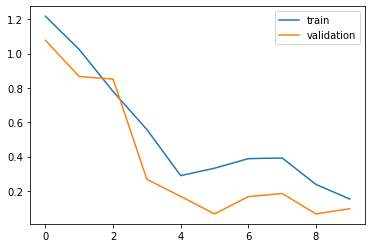

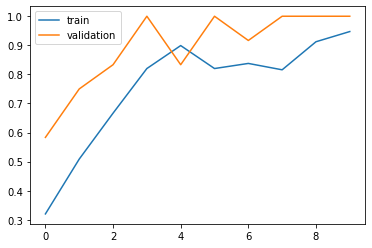

In [29]:
y_pred =model_2.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(precision_recall_fscore_support(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.legend(["train", "validation"])
plt.show()

plt.plot(history_2.history["accuracy"])
plt.plot(history_2.history["val_accuracy"])
plt.legend(["train", "validation"])
plt.show()

In [30]:
def create_cnn_model_2(inShape, convNum, hNum, hAct, outNum, loss):
    """
    :param inShape: kształt wejścia, h*w*c
    :param convNum: lista ilości featerów w warstwach konwolucyjnych
    :param hNum: lista ilości neuronów w poszczególnych warstwach ukrytych
    :param hAct: rodzaj aktywacji w warstwach ukrytych, str
    :param outNum: ilość neuronów
    :param loss: funkcja kosztu
    """
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(inShape)))
    for idx, oneConvNum in enumerate(convNum):
        model.add(layers.Conv2D(filters=oneConvNum,kernel_size=3,strides=1,padding="SAME",activation="relu"))
        model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2,padding="SAME"))
    model.add(layers.Flatten())
    for idx, oneHidNum in enumerate(hNum):
        model.add(layers.Dense(oneHidNum, activation=hAct))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(outNum,activation='softmax'))
    print(model.summary())
    
    opt = tf.keras.optimizers.Adam()
    
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=["accuracy"]
    )
    
    return model

In [31]:
model_3 = create_cnn_model_2(
    inShape=x_train.shape[1:],
    convNum=[32,64,128],
    hNum=[100],
    hAct="relu",
    outNum=3,
    loss=tf.keras.losses.CategoricalCrossentropy()
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)           

In [32]:
# dodajemy zapisywanie logów do tensorboard'a
log_dir = "logs\\" + "model_3"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [33]:
start = time()
history_3 = model_3.fit(
    x=x_train,
    y=y_train,
    batch_size=33,
    epochs=10,
    validation_split=0.05,
    callbacks=[tensorboard_callback]
)
end = time()
time_model_3 = round(end-start,4)

Epoch 1/10
7/7 [==============================] - 12s 2s/step - loss: 1.9574 - accuracy: 0.3772 - val_loss: 0.9580 - val_accuracy: 0.6667
Epoch 2/10
7/7 [==============================] - 9s 1s/step - loss: 0.9184 - accuracy: 0.5175 - val_loss: 0.6648 - val_accuracy: 0.7500
Epoch 3/10
7/7 [==============================] - 8s 1s/step - loss: 0.5392 - accuracy: 0.7632 - val_loss: 0.3268 - val_accuracy: 0.7500
Epoch 4/10
7/7 [==============================] - 8s 1s/step - loss: 0.2208 - accuracy: 0.9474 - val_loss: 0.0773 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 7s 1s/step - loss: 0.0830 - accuracy: 0.9649 - val_loss: 0.0995 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 8s 1s/step - loss: 0.0589 - accuracy: 0.9825 - val_loss: 0.0637 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 8s 1s/step - loss: 0.0280 - accuracy: 0.9956 - val_loss: 0.0183 - val_accuracy: 1.0000
Epoch 8/10
7/7 [========================

In [34]:
model_3.save_weights("weights/model_3")

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.96      1.00      0.98        23
           2       0.94      1.00      0.97        17

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



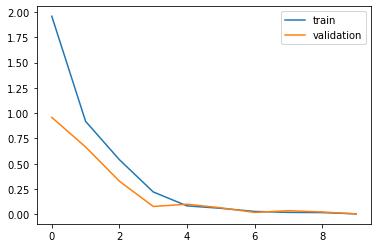

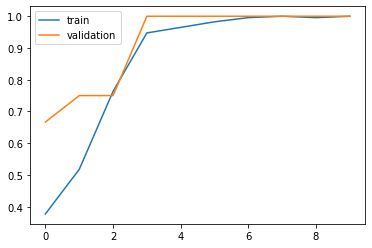

In [35]:
y_pred = model_3.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

plt.plot(history_3.history["loss"])
plt.plot(history_3.history["val_loss"])
plt.legend(["train", "validation"])
plt.show()

plt.plot(history_3.history["accuracy"])
plt.plot(history_3.history["val_accuracy"])
plt.legend(["train", "validation"])
plt.show()

In [ ]:
# # zamiana danych na sekwencję, wymagają tego warstwy rekurencyjne
# # długość sekwencji zależy od tego po jakiej ilości próbek w czasie chcemy aby rekurencja chodziła
# def ConvertDataToSequence(data, windowLen, featNum):
#     """
#     :param data: dane w postaci szeregu, typu numpy.array
#     :param windowLen: długość okna czyli sekwencji
#     :param featNum: ilość cech w ramach szeregu
#     """
#     #długość wejściowego szeregu
#     lenOfAllSeq = data.shape[0]
#     # pusty kontener na kolejne sekwencje
#     xSeq = []
#     # idziemy po szeregu i tworzymy z niego sekwencje
#     for i in range(lenOfAllSeq-windowLen):
#         xSeq.append(data[i:i+windowLen])
#     xSeq = np.array(xSeq).reshape(-1,windowLen,featNum,224,224,3)
    
#     # definiujemy wartości następujące po każdej sekwencji, będą to nasze wyjścia
#     ySeq = data[windowLen:,0].reshape(-1,1)
    
#     return xSeq, ySeq

# seqLen = 100
# featNum = 25
# xSeq, ySeq = ConvertDataToSequence(x, 100, 25)
# print(f"sequence shape: {xSeq.shape}")
# print(f"output shape: {ySeq.shape}")

# xSeq_train,xSeq_test,ySeq_train,ySeq_test = train_test_split(xSeq, ySeq, test_size=0.2, random_state=123)

# model_4 = tf.keras.Sequential()
# model_4.add(layers.InputLayer(input_shape=(7,2)))
# model_4.add(layers.LSTM(units=256,name="rekurencja_pierwsza",return_sequences=True))
# model_4.add(layers.Dropout(0.2))
# model_4.add(layers.LSTM(units=256,name="rekurencja_druga",return_sequences=True))
# model_4.add(layers.Dense(units=256,activation="relu"))
# model_4.add(layers.Dropout(0.2))
# model_4.add(layers.LSTM(units=128,name="rekurencja_trzecia"))
# model_4.add(layers.Dense(units=128,activation="relu"))
# model_4.add(layers.Dropout(0.2))
# model_4.add(layers.Dense(units=3,name="wyjscie"))
# model_4.summary()

# opt = tf.keras.optimizers.Adam()
# loss=tf.keras.losses.CategoricalCrossentropy()
# model_4.compile(optimizer=opt,loss=loss,metrics=["accuracy"])

# # dodajemy zapisywanie logów do tensorboard'a
# log_dir = "logs\\" + "model_4 (model rekurencyjny)"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# start = time()
# history_4 = model_4.fit(x=x_train,y=y_train,batch_size=33,epochs=10,validation_split=0.05,callbacks=[tensorboard_callback])
# end = time()
# time_model_4 = round(end-start,4)

# model_4.save_weights("weights/model_4")

# y_pred = model_4.predict(x_test)
# print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
# print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
# print(precision_recall_fscore_support(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

# plt.plot(history_4.history["loss"])
# plt.plot(history_4.history["val_loss"])
# plt.legend(["train", "validation"])
# plt.show()

# plt.plot(history_4.history["accuracy"])
# plt.plot(history_4.history["val_accuracy"])
# plt.legend(["train", "validation"])
# plt.show()

In [36]:
print(f'Model 1: {time_model_1}')
print(f'Model 2: {time_model_2}')
print(f'Model 3: {time_model_3}')

Model 1: 195.6992
Model 2: 103.5785
Model 3: 89.8268


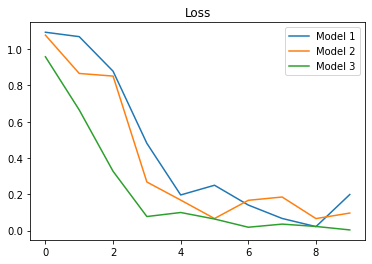

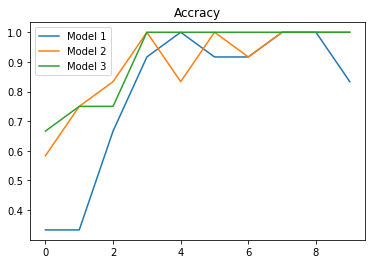

In [101]:
plt.plot(history_1.history["val_loss"])
plt.plot(history_2.history["val_loss"])
plt.plot(history_3.history["val_loss"])
plt.legend(["Model 1", "Model 2", "Model 3"])
plt.title("Loss")
plt.show()

plt.plot(history_1.history["val_accuracy"])
plt.plot(history_2.history["val_accuracy"])
plt.plot(history_3.history["val_accuracy"])
plt.legend(["Model 1", "Model 2", "Model 3"])
plt.title("Accracy")
plt.show()

In [37]:
# wejście
inputLayer = tf.keras.Input(shape=(x_train.shape[1:]))

In [38]:
MobileNetV2_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
DenseNet121_model = tf.keras.applications.DenseNet121(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
MobileNet_model = tf.keras.applications.MobileNet(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
Xception1_model = tf.keras.applications.Xception(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
DenseNet169_model = tf.keras.applications.DenseNet169(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)

models = [MobileNetV2_model,DenseNet121_model,MobileNet_model,Xception1_model,DenseNet169_model]

In [39]:
for model in models:
    model.trainable = False

In [40]:
x_train.shape[1:]

(224, 224, 3)

In [41]:
m = MobileNetV2_model(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.2)(m)
output = layers.Dense(3)(m)
MobileNetV2_model = tf.keras.Model(inputLayer, output)
MobileNetV2_model.summary()
# kompilujemy całość
MobileNetV2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"],)
# dodajemy zapisywanie logów do tensorboard'a
log_dir = "logs\\" + "MobileNetV2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
start = time()
# trening z podaniem callbacków
history_5 = MobileNetV2_model.fit(x=x_train,y=y_train,batch_size=33,epochs=10,validation_split=0.05,callbacks=[tensorboard_callback])
end = time()
time_MobileNetV2 = round(end-start,4)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10


c:\Users\iwona\anaconda3\envs\DeepLearning\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


7/7 [==============================] - 14s 1s/step - loss: 0.7571 - accuracy: 0.5482 - val_loss: 0.2092 - val_accuracy: 0.8333
Epoch 2/10
7/7 [==============================] - 3s 402ms/step - loss: 0.1887 - accuracy: 0.9035 - val_loss: 0.2630 - val_accuracy: 0.7500
Epoch 3/10
7/7 [==============================] - 2s 326ms/step - loss: 0.1166 - accuracy: 0.9474 - val_loss: 0.0277 - val_accuracy: 1.0000
Epoch 4/10
7/7 [==============================] - 2s 315ms/step - loss: 0.0555 - accuracy: 0.9825 - val_loss: 0.0483 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 2s 298ms/step - loss: 0.0383 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 2s 340ms/step - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 2s 293ms/step - loss: 0.0245 - accuracy: 0.9956 - val_loss: 0.0329 - val_accuracy: 1.0000
Epoch 8/10
7/7 [=================

In [42]:
MobileNetV2_model.save_weights("weights/MobileNetV2_model")

In [43]:
m = DenseNet121_model(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.2)(m)
output = layers.Dense(3)(m)
DenseNet121_model = tf.keras.Model(inputLayer, output)
DenseNet121_model.summary()
# kompilujemy całość
DenseNet121_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"],)
# dodajemy zapisywanie logów do tensorboard'a
log_dir = "logs\\" + "DenseNet121"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
start = time()
# trening z podaniem callbacków
history_6 = DenseNet121_model.fit(x=x_train,y=y_train,batch_size=33,epochs=10,validation_split=0.05,callbacks=[tensorboard_callback])
end = time()
time_DenseNet121 = round(end-start,4)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 31s 3s/step - loss: 0.6125 - accuracy: 0.6184 - val_loss: 0.2

In [44]:
DenseNet121_model.save_weights("weights/DenseNet121_model")

In [45]:
m = MobileNet_model(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.2)(m)
output = layers.Dense(3)(m)
MobileNet_model = tf.keras.Model(inputLayer, output)
MobileNet_model.summary()
# kompilujemy całość
MobileNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"],)
# dodajemy zapisywanie logów do tensorboard'a
log_dir = "logs\\" + "MobileNet"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
start = time()
# trening z podaniem callbacków
history_7 = MobileNet_model.fit(x=x_train,y=y_train,batch_size=33,epochs=10,validation_split=0.05,callbacks=[tensorboard_callback])
end = time()
time_MobileNet = round(end-start,4)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,075
Non-trainable params: 3,228,864
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 12s 2s/step - loss: 0.6515 - accuracy: 0.6316 - val_loss: 0.2

In [46]:
MobileNet_model.save_weights("weights/MobileNet_model")

In [47]:
m = Xception1_model(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.2)(m)
output = layers.Dense(3)(m)
Xception1_model = tf.keras.Model(inputLayer, output)
Xception1_model.summary()
# kompilujemy całość
Xception1_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"],)
# dodajemy zapisywanie logów do tensorboard'a
log_dir = "logs\\" + "Xception1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
start = time()
# trening z podaniem callbacków
history_8 = Xception1_model.fit(x=x_train,y=y_train,batch_size=33,epochs=10,validation_split=0.05,callbacks=[tensorboard_callback])
end = time()
time_Xception1 = round(end-start,4)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 22s 3s/step - loss: 0.4215 - accuracy: 0.8158 - val_loss: 0

In [48]:
Xception1_model.save_weights("weights/Xception1_model")

In [49]:
m = DenseNet169_model(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.2)(m)
output = layers.Dense(3)(m)
DenseNet169_model = tf.keras.Model(inputLayer, output)
DenseNet169_model.summary()
# kompilujemy całość
DenseNet169_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"],)
# dodajemy zapisywanie logów do tensorboard'a
log_dir = "logs\\" + "DenseNet169"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
start = time()
# trening z podaniem callbacków
history_9 = DenseNet169_model.fit(x=x_train,y=y_train,batch_size=33,epochs=10,validation_split=0.05,callbacks=[tensorboard_callback])
end = time()
time_DenseNet169 = round(end-start,4)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1664)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1664)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 4995      
Total params: 12,647,875
Trainable params: 4,995
Non-trainable params: 12,642,880
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 39s 4s/step - loss: 0.7082 - accuracy: 0.5746 - val_loss: 0

In [50]:
DenseNet169_model.save_weights("weights/DenseNet169_model")

Model MobileNetV2: 37.6495
Model DenseNet121: 109.0119
Model MobileNet: 35.3663
Model Xception1: 141.6641
Model DenseNet169: 138.3645


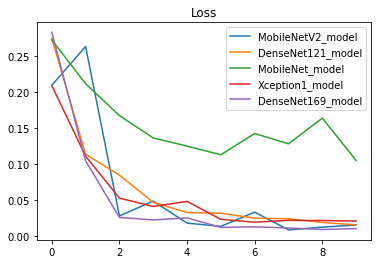

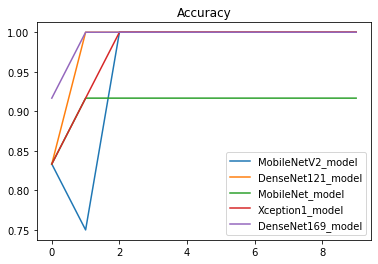

In [102]:
print(f'Model MobileNetV2: {time_MobileNetV2}')
print(f'Model DenseNet121: {time_DenseNet121}')
print(f'Model MobileNet: {time_MobileNet}')
print(f'Model Xception1: {time_Xception1}')
print(f'Model DenseNet169: {time_DenseNet169}')

plt.plot(history_5.history["val_loss"])
plt.plot(history_6.history["val_loss"])
plt.plot(history_7.history["val_loss"])
plt.plot(history_8.history["val_loss"])
plt.plot(history_9.history["val_loss"])
plt.legend(['MobileNetV2_model','DenseNet121_model','MobileNet_model','Xception1_model','DenseNet169_model'])
plt.title('Loss')
plt.show()

plt.plot(history_5.history["val_accuracy"])
plt.plot(history_6.history["val_accuracy"])
plt.plot(history_7.history["val_accuracy"])
plt.plot(history_8.history["val_accuracy"])
plt.plot(history_9.history["val_accuracy"])
plt.legend(['MobileNetV2_model','DenseNet121_model','MobileNet_model','Xception1_model','DenseNet169_model'])
plt.title('Accuracy')
plt.show()

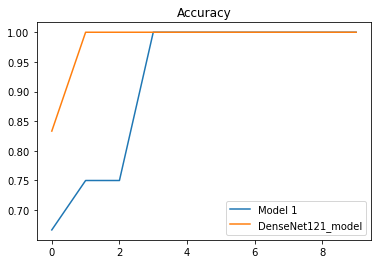

Model MobileNetV2: 89.8268
Model DenseNet121: 109.0119


In [105]:
plt.plot(history_3.history["val_accuracy"])
plt.plot(history_6.history["val_accuracy"])
plt.legend(['Model 1','DenseNet121_model'])
plt.title('Accuracy')
plt.show()

print(f'Model MobileNetV2: {time_model_3}')
print(f'Model DenseNet121: {time_DenseNet121}')

In [ ]:
# fig = go.Figure()

# # fig.add_trace(go.Scatter(y=history_1.history['val_loss'],mode='lines',name='model_1'))
# # fig.add_trace(go.Scatter(y=history_2.history['val_loss'],mode='lines',name='modelCNN'))
# # fig.add_trace(go.Scatter(y=history_3.history['val_loss'],mode='lines',name='modelCnn_2'))
# fig.add_trace(go.Scatter(y=history_4.history['val_loss'],mode='lines',name='MobileNetV2_model'))
# fig.add_trace(go.Scatter(y=history_5.history['val_loss'],mode='lines',name='DenseNet121_model'))
# fig.add_trace(go.Scatter(y=history_6.history['val_loss'],mode='lines',name='MobileNet_model'))
# fig.add_trace(go.Scatter(y=history_7.history['val_loss'],mode='lines',name='Xception1_model'))
# fig.add_trace(go.Scatter(y=history_8.history['val_loss'],mode='lines',name='DenseNet169_model'))
# # px.line(history_5.history, y=history_5.history['val_loss'],labels={'DenseNet121_model'}, title='Training History')


# Model DenseNet121- testowanie parametrów

In [52]:
# wejście
inputLayer = tf.keras.Input(shape=(x_train.shape[1:]))

In [53]:
final_model1 = tf.keras.applications.DenseNet121(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
final_model1.trainable = False

In [54]:
m = final_model1(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.0)(m)
output = layers.Dense(3)(m)
final_model1 = tf.keras.Model(inputLayer, output)
final_model1.summary()
log_dir = "logs\\" + "Final(Dropout0.0+batch_size33+learning_rate0.01)"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# kompilujemy całość
final_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"])
# trening z podaniem callbacków
start = time()
history_final1 = final_model1.fit(x=x_train,y=y_train,batch_size=33,epochs=10,validation_split=0.05,callbacks=[tensorboard_callback])
end = time()
time_final1 = round(end-start,4)

final_model1.save_weights("weights/final_model1")

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 32s 4s/step - loss: 0.7484 - accuracy: 0.4561 - val_loss: 0.4

In [55]:
final_model2 = tf.keras.applications.DenseNet121(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
final_model2.trainable = False

In [56]:
m = final_model2(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.3)(m)
output = layers.Dense(3)(m)
final_model2 = tf.keras.Model(inputLayer, output)
final_model2.summary()
log_dir = "logs\\" + "Final(Dropout0.3+batch_size33+learning_rate0.01)"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# kompilujemy całość
final_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"])
# trening z podaniem callbacków
start = time()
history_final2 = final_model2.fit(x=x_train,y=y_train,batch_size=33,epochs=10,validation_split=0.05,callbacks=[tensorboard_callback])
end = time()
time_final2 = round(end-start,4)

final_model2.save_weights("weights/final_model_do_0.3")

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 32s 4s/step - loss: 0.7313 - accuracy: 0.5439 - val_loss: 0.2

In [57]:
final_model3 = tf.keras.applications.DenseNet121(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
final_model3.trainable = False

In [58]:
m = final_model3(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.8)(m)
output = layers.Dense(3)(m)
final_model3 = tf.keras.Model(inputLayer, output)
final_model3.summary()
log_dir = "logs\\" + "Final(Dropout0.8+batch_size33+learning_rate0.01)"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# kompilujemy całość
final_model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"])
# trening z podaniem callbacków
start = time()
history_final3 = final_model3.fit(x=x_train,y=y_train,batch_size=33,epochs=10,validation_split=0.05,callbacks=[tensorboard_callback])
end = time()
time_final3 = round(end-start,4)

final_model3.save_weights("weights/final_model_do_0.8")

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1024)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 34s 4s/step - loss: 0.9492 - accuracy: 0.4693 - val_loss: 0.2

Dropout = 0.3

In [59]:
(x_train.shape[0]*0.95)//115

1.0

In [60]:
final_model4 = tf.keras.applications.DenseNet121(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
final_model4.trainable = False

In [61]:
m = final_model4(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.3)(m)
output = layers.Dense(3)(m)
final_model4 = tf.keras.Model(inputLayer, output)
final_model4.summary()
log_dir = "logs\\" + "Final(Dropout0.3+batch_size115+learning_rate0.01)"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# kompilujemy całość
final_model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"])
# trening z podaniem callbacków
start = time()
history_final4 = final_model4.fit(x=x_train,y=y_train,batch_size=115,epochs=10,validation_split=0.05,callbacks=[tensorboard_callback])
end = time()
time_final4 = round(end-start,4)

final_model4.save_weights("weights/final_model_bs_115")

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1024)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 30s 18s/step - loss: 0.8387 - accuracy: 0.3728 - val_loss: 0.

In [62]:
final_model5 = tf.keras.applications.DenseNet121(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
final_model5.trainable = False

In [63]:
m = final_model5(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.3)(m)
output = layers.Dense(3)(m)
final_model5 = tf.keras.Model(inputLayer, output)
final_model5.summary()
log_dir = "logs\\" + "Final(Dropout0.3+batch_size12+learning_rate0.01)"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# kompilujemy całość
final_model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"])
# trening z podaniem callbacków
start = time()
history_final5 = final_model5.fit(x=x_train,y=y_train,batch_size=12,epochs=10,validation_split=0.05,callbacks=[tensorboard_callback])
end = time()
time_final5 = round(end-start,4)

final_model5.save_weights("weights/final_model_bs_12")

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1024)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/10
19/19 [==============================] - 37s 1s/step - loss: 0.6567 - accuracy: 0.6184 - val_loss: 0

Batch size 12

In [64]:
final_model6 = tf.keras.applications.DenseNet121(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
final_model6.trainable = False

In [65]:
m = final_model6(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.3)(m)
output = layers.Dense(3)(m)
final_model6 = tf.keras.Model(inputLayer, output)
final_model6.summary()
log_dir = "logs\\" + "Final(Dropout0.3+batch_size12+learning_rate0.001)"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# kompilujemy całość
final_model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"])
# trening z podaniem callbacków
start = time()
history_final6 = final_model6.fit(x=x_train,y=y_train,batch_size=12,epochs=10,validation_split=0.05,callbacks=[tensorboard_callback])
end = time()
time_final6 = round(end-start,4)

final_model6.save_weights("weights/final_model_lr_001")

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_10  (None, 1024)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/10
19/19 [==============================] - 33s 1s/step - loss: 0.7182 - accuracy: 0.3377 - val_loss: 

In [66]:
final_model7 = tf.keras.applications.DenseNet121(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
final_model7.trainable = False

In [67]:
m = final_model7(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.3)(m)
output = layers.Dense(3)(m)
final_model7 = tf.keras.Model(inputLayer, output)
final_model7.summary()
log_dir = "logs\\" + "Final(Dropout0.3+batch_size12+learning_rate0.1)"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# kompilujemy całość
final_model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"])
# trening z podaniem callbacków
start = time()
history_final7 = final_model7.fit(x=x_train,y=y_train,batch_size=12,epochs=10,validation_split=0.05,callbacks=[tensorboard_callback])
end = time()
time_final7 = round(end-start,4)

final_model7.save_weights("weights/final_model_lr_1")

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_11  (None, 1024)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/10
19/19 [==============================] - 34s 1s/step - loss: 3.8294 - accuracy: 0.6798 - val_loss: 

learning rate 0.01

# Testowanie

In [68]:
# wszystkie zdjecia w takim samym rozmiarze
all_x = []
for i in range(len(data_df.path)):
    img = plt.imread(data_df.path[i])
    img = cv2.resize(img, (224,224))
    all_x.append(img)
all_x = np.array(all_x)
all_y = np.array(data_df['label'])
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(all_x, all_y, test_size=0.2, random_state=123)
x_train_all = x_train_all.astype(np.float32)
x_test_all = x_test_all.astype(np.float32)
# transformujemy y_test
y_test_all = OneHotEncoder().fit_transform(y_test_all.reshape(-1,1)).toarray()
# podglądamy
y_test_all = y_test_all.astype(np.float32)

# transformujemy y_train
y_train_all = OneHotEncoder().fit_transform(y_train_all.reshape(-1,1)).toarray()
# podglądamy
y_train_all = y_train_all.astype(np.float32)

print("y_test.shape: ", y_test_all.shape)
print("y_train.shape: ", y_train_all.shape)
x_test_all = x_test_all.reshape(-1,224,224,3)
x_train_all = x_train_all.reshape(-1,224,224,3)

y_test.shape:  (1233, 3)
y_train.shape:  (4928, 3)


In [69]:
(x_train_all.shape[0]*0.95)%196

173.59999999999945

In [70]:
# wejście
inputLayer = tf.keras.Input(shape=(x_train_all.shape[1:]))

In [71]:
FinalModel = tf.keras.applications.DenseNet121(weights='imagenet',input_shape=x_train_all.shape[1:],include_top=False)
FinalModel.trainable = False

In [72]:
m = FinalModel(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.3)(m)
output = layers.Dense(3)(m)
FinalModel = tf.keras.Model(inputLayer, output)
FinalModel.summary()
log_dir = "logs\\" + "FinalModel"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# kompilujemy całość
FinalModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"])
# trening z podaniem callbacków
start = time()
history_FinalModel = FinalModel.fit(x=x_train_all,y=y_train_all,batch_size=196,epochs=10,validation_data=(x_test_all,y_test_all),callbacks=[tensorboard_callback])
end = time()
time_FinalModel = round(end-start,4)

FinalModel.save_weights("weights/FinalModel")

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_12  (None, 1024)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/10
26/26 [==============================] - 200s 7s/step - loss: 0.4028 - accuracy: 0.8216 - val_loss:

In [73]:
y_pred_FinalModel =FinalModel.predict(x_test_all)
print(classification_report(y_test_all.argmax(axis=1), y_pred_FinalModel.argmax(axis=1)))

# Score trained model.
scores_FinalModel = FinalModel.evaluate(x_test_all, y_test_all, verbose=1)
print('Test loss:', scores_FinalModel[0])
print('Test accuracy:', scores_FinalModel[1])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       485
           1       1.00      0.99      1.00       138
           2       1.00      1.00      1.00       610

    accuracy                           1.00      1233
   macro avg       1.00      1.00      1.00      1233
weighted avg       1.00      1.00      1.00      1233

39/39 [==============================] - 38s 982ms/step - loss: 0.0073 - accuracy: 0.9992
Test loss: 0.007264228537678719
Test accuracy: 0.9991889595985413


In [75]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

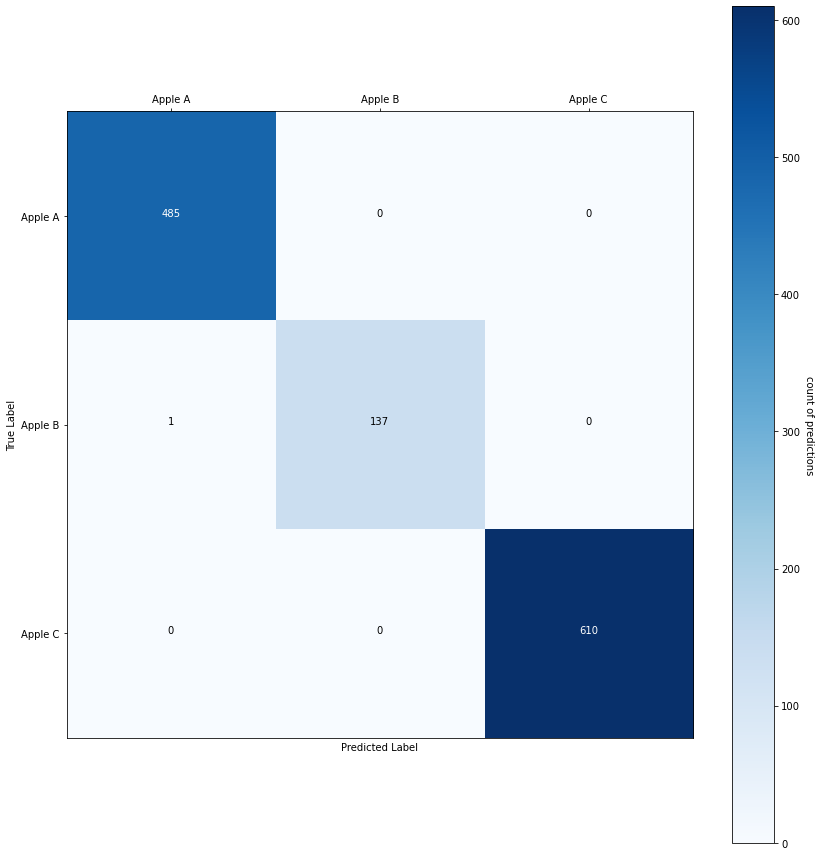

In [76]:
labels = ['Apple A', 'Apple B', 'Apple C']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(y_pred_FinalModel, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_all, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = y_pred_FinalModel[errors]
Y_true_errors = Y_true[errors]
# X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues)
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [77]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3)])

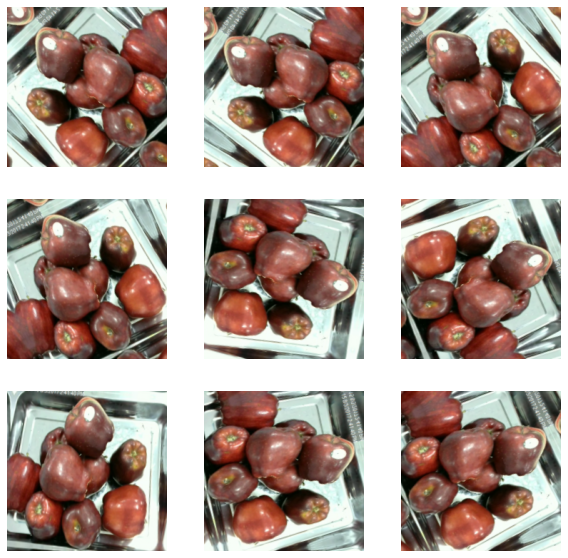

In [78]:
plt.figure(figsize=(10, 10))
first_image = x[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

In [79]:
FinalModel_aug_data = tf.keras.applications.DenseNet121(weights='imagenet',input_shape=x_train_all.shape[1:],include_top=False)
FinalModel_aug_data.trainable = False

In [80]:
m = data_augmentation(inputLayer)
m = FinalModel_aug_data(m, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.3)(m)
output = layers.Dense(3)(m)
FinalModel_aug_data = tf.keras.Model(inputLayer, output)
FinalModel_aug_data.summary()
log_dir = "logs\\" + "FinalModel_aug_data"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# kompilujemy całość
FinalModel_aug_data.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"])

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_13  (None, 1024)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
____________________________________________

In [81]:
start = time()
history_FinalModel_aug_data2 = FinalModel_aug_data.fit(x=x_train_all,y=y_train_all,batch_size=196,epochs=10,validation_data=(x_test_all,y_test_all),callbacks=[tensorboard_callback])
end = time()
time_FinalModel_aug_data = round(end-start,4)

FinalModel_aug_data.save_weights("weights/FinalModel_aug_data")

Epoch 1/10
26/26 [==============================] - 230s 8s/step - loss: 0.4295 - accuracy: 0.7989 - val_loss: 0.0956 - val_accuracy: 0.9643
Epoch 2/10
26/26 [==============================] - 181s 7s/step - loss: 0.0860 - accuracy: 0.9704 - val_loss: 0.0407 - val_accuracy: 0.9870
Epoch 3/10
26/26 [==============================] - 174s 7s/step - loss: 0.0552 - accuracy: 0.9848 - val_loss: 0.0272 - val_accuracy: 0.9935
Epoch 4/10
26/26 [==============================] - 170s 7s/step - loss: 0.0420 - accuracy: 0.9907 - val_loss: 0.0210 - val_accuracy: 0.9951
Epoch 5/10
26/26 [==============================] - 169s 7s/step - loss: 0.0358 - accuracy: 0.9915 - val_loss: 0.0171 - val_accuracy: 0.9959
Epoch 6/10
26/26 [==============================] - 169s 7s/step - loss: 0.0341 - accuracy: 0.9909 - val_loss: 0.0163 - val_accuracy: 0.9968
Epoch 7/10
26/26 [==============================] - 169s 7s/step - loss: 0.0293 - accuracy: 0.9915 - val_loss: 0.0140 - val_accuracy: 0.9959
Epoch 8/10
26

In [82]:
y_pred_FinalModel_aug_data =FinalModel_aug_data.predict(x_test_all)
print(classification_report(y_test_all.argmax(axis=1), y_pred_FinalModel_aug_data.argmax(axis=1)))

# Score trained model.
scores_FinalModel_aug_data = FinalModel_aug_data.evaluate(x_test_all, y_test_all, verbose=1)
print('Test loss:', scores_FinalModel_aug_data[0])
print('Test accuracy:', scores_FinalModel_aug_data[1])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       485
           1       1.00      0.99      0.99       138
           2       1.00      1.00      1.00       610

    accuracy                           1.00      1233
   macro avg       1.00      0.99      1.00      1233
weighted avg       1.00      1.00      1.00      1233

39/39 [==============================] - 40s 1s/step - loss: 0.0115 - accuracy: 0.9968
Test loss: 0.011546657420694828
Test accuracy: 0.9967558979988098


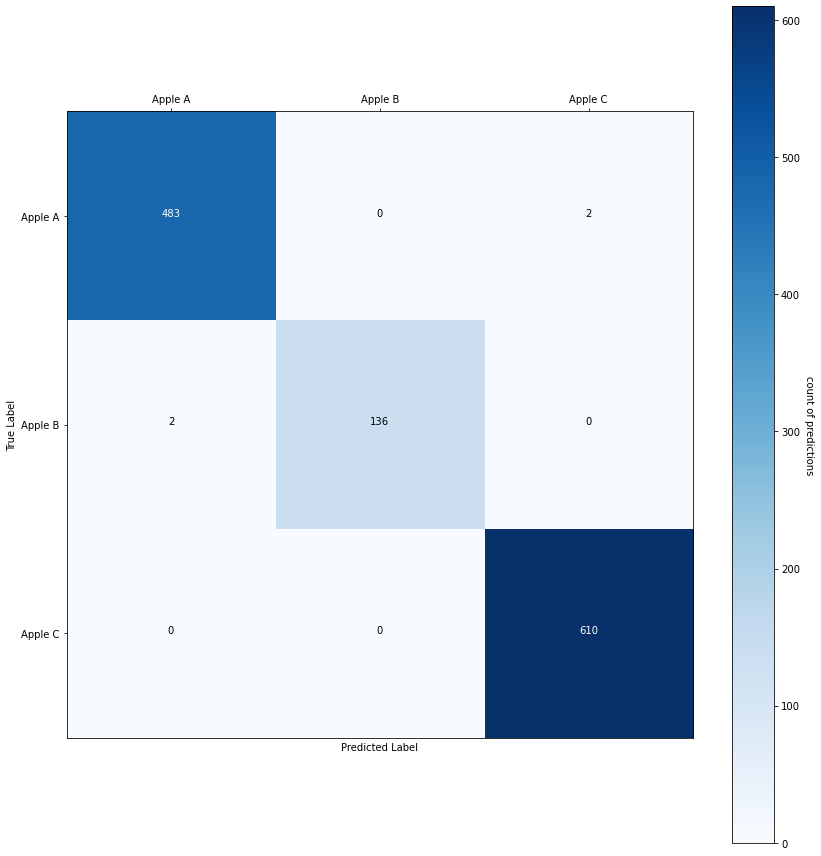

In [83]:
labels = ['Apple A', 'Apple B', 'Apple C']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(y_pred_FinalModel_aug_data, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_all, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = y_pred_FinalModel_aug_data[errors]
Y_true_errors = Y_true[errors]
# X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

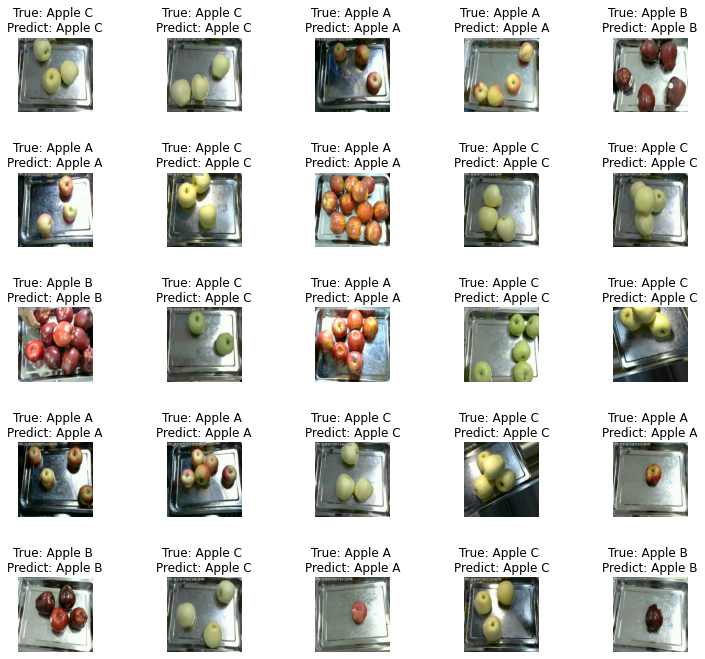

In [84]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test_all[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

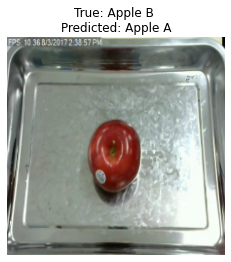

In [85]:
misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
plt.imshow(x_test_all[misclassified_idx[0]])
plt.title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[0]]], labels[Y_pred_classes[misclassified_idx[0]]]))
plt.axis('off')
plt.show()

# ML

In [86]:
def gen_raw_feature(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(img, (50, 50))
    return img_resize.flatten()
data_df['feature_raw'] = data_df['path'].apply(gen_raw_feature)
data_df.shape

(6161, 4)

In [87]:
all_types = data_df['fruit'].unique()
fruit_ids = {}
fruit_types = {}
for i, f in enumerate(all_types):
    fruit_ids[f] = i
    fruit_types[i] = f

In [88]:
x = data_df['feature_raw']
y = data_df['label']
y_name = data_df['fruit']

In [89]:
y_name.shape

(6161,)

In [90]:
x_train, _x, y_train, _y = train_test_split(x, y, train_size=0.6, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(_x, _y, train_size=0.5, stratify=_y)

In [91]:
x_val.shape

(1232,)

In [92]:
x_train = np.stack(x_train)
scaler = StandardScaler()
scaler.fit(x_train)
x_train_norm = scaler.transform(x_train)
x_val = scaler.transform(np.stack(x_val))
x_test = scaler.transform(np.stack(x_test))

In [93]:
x_val.shape

(1232, 7500)

In [94]:
pca = PCA(n_components=2)
x_r = pca.fit(x_train).transform(x_train)
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
lda = LinearDiscriminantAnalysis(n_components=2)
x_r2 = lda.fit(x_train, y_train).transform(x_train)

explained variance ratio (first two components): [0.15469869 0.0931895 ]


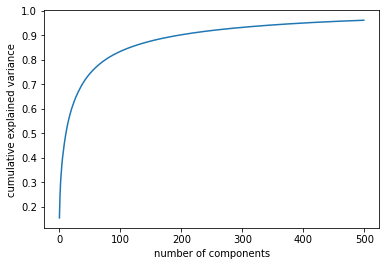

(Minimum) number of components that explains 90% of the variance in the train data: 197


In [95]:
pca = PCA(n_components=500)
pca.fit(x_train)
cum_explnd_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explnd_var)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()
num_of_pca_comp = next(i for i,s in enumerate(cum_explnd_var) if s > 0.9)
print("(Minimum) number of components that explains 90% of the variance in the train data: {}".format(num_of_pca_comp))

In [96]:
pca = PCA(n_components=196)
pca.fit(x_train)
xp_train = pca.transform(x_train_norm)
xp_validate = pca.transform(x_val)
xp_test = pca.transform(x_test)

In [97]:
def show_conf_matrix(y_true, y_pred):
    logreg_conf = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(24, 12))
    sns.heatmap(logreg_conf, annot=True, cmap='Blues', \
                xticklabels=fruit_types.values(), yticklabels=fruit_types.values())
    plt.show()
    print(classification_report(y_test, ypred_test, target_names=fruit_types.values()))

In [108]:
logreg = LogisticRegression(C=1)
# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(xp_train, y_train)
ypred_test = logreg.predict(xp_test)

c:\Users\iwona\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


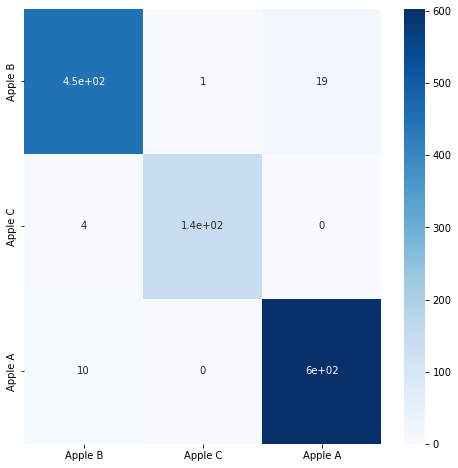

              precision    recall  f1-score   support

     Apple B       0.97      0.96      0.96       472
     Apple C       0.99      0.97      0.98       148
     Apple A       0.97      0.98      0.98       613

    accuracy                           0.97      1233
   macro avg       0.98      0.97      0.97      1233
weighted avg       0.97      0.97      0.97      1233



In [110]:
show_conf_matrix(y_test, ypred_test)

# Apka

In [ ]:
# # y_pred = DenseNet121_model.predict(x_test)
# y_pred = tf.nn.softmax(DenseNet121_model.predict(x_test)).numpy().argmax(axis=1)

In [ ]:
# y_pred_proba = tf.nn.softmax(DenseNet121_model.predict_proba(x_test)).numpy().argmax(axis=1)

In [ ]:
# img = cv2.cvtColor(cv2.imread("data/Apple/Apple A/Apple 57.png"), cv2.COLOR_BGR2RGB)
# img = img/255
# img = cv2.resize(img, (224,224))
# img = np.array(img)
# plt.imshow(img)
# plt.show()
# img2 = img.reshape(-1,224,224,3)

In [ ]:
# y_p = DenseNet121_model.predict(img2)
# y_pred = tf.nn.softmax(DenseNet121_model.predict(img)).numpy().argmax(axis=1)
# a=np.greater_equal(DenseNet121_model.predict(img2),0.5).astype(np.int32)
# ynew = DenseNet121_model.predict_proba(img2)

In [ ]:
# # example making new probability predictions for a classification problem
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from sklearn.datasets import make_blobs
# from sklearn.preprocessing import MinMaxScaler
# # generate 2d classification dataset
# X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=1)
# scalar = MinMaxScaler()
# scalar.fit(X)
# X = scalar.transform(X)
# # define and fit the final model
# model = Sequential()
# model.add(Dense(4, input_dim=2, activation='relu'))
# model.add(Dense(4, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam')
# model.fit(X, y, epochs=500, verbose=0)
# # new instances where we do not know the answer
# Xnew, _ = make_blobs(n_samples=3, centers=2, n_features=2, random_state=1)
# Xnew = scalar.transform(Xnew)
# # make a prediction
# ynew = model.predict_proba(Xnew)
# # show the inputs and predicted outputs
# for i in range(len(Xnew)):
# 	print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))